Import dependencies

In [1]:
import datetime
import numpy as np 
import pandas as pd
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier )
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
import yfinance as yf

Download data

In [2]:
n_estimators = 400
n_jobs = 1
random_state = 42
lookback_minutes = 30
lookforward_minutes = 5
up_down_factor=2.0
percent_factor=0.01

spx = yf.download('SPY')
spx = spx.dropna()
spx.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.96875,43.96875,43.75000,43.93750,26.184059,1003200
1993-02-01,43.96875,44.25000,43.96875,44.25000,26.370279,480500
1993-02-02,44.21875,44.37500,44.12500,44.34375,26.426161,201300
1993-02-03,44.40625,44.84375,44.37500,44.81250,26.705482,529400
1993-02-04,44.96875,45.09375,44.46875,45.00000,26.817228,531500


Prepare lookbacks and lookforwards columns

In [3]:
spx.drop(['Open', 'Low', 'High', 'Volume', 'Adj Close'], axis=1, inplace=True)

for i in range(0,lookback_minutes):
    spx['Lookback%s' % str(i+1)] = spx['Close'].shift(i+1)
    
for i in range(0,lookforward_minutes):
    spx['Lookforward%s' % str(i+1)] = spx['Close'].shift(-(i+1))
    
spx.dropna(inplace=True)

spx['Lookback0'] = spx['Close'].pct_change()*100
for i in range(0,lookback_minutes):
    spx['Lookback%s' % str(i+1)] = spx['Lookback%s' % str(i+1)].pct_change()*100
    
for i in range(0,lookforward_minutes):
    spx['Lookforward%s' % str(i+1)] = spx['Lookforward%s' % str(i+1)].pct_change()*100
    
spx.dropna(inplace=True)
spx.head()

,Close,Lookback1,Lookback2,Lookback3,Lookback4,Lookback5,Lookback6,Lookback7,Lookback8,Lookback9,...,Lookback27,Lookback28,Lookback29,Lookback30,Lookforward1,Lookforward2,Lookforward3,Lookforward4,Lookforward5,Lookback0
Date,,,,,,,,,,,,,,,,,,,,,
1993-03-16,45.31250,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,-0.278552,-0.554017,0.417246,...,0.418410,1.057082,0.211864,0.711238,-0.620690,0.624566,-0.620690,-0.555170,0.209351,0.000000
1993-03-17,45.03125,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,-0.278552,-0.554017,...,-0.069444,0.418410,1.057082,0.211864,0.624566,-0.620690,-0.555170,0.209351,0.000000,-0.620690
1993-03-18,45.31250,-0.620690,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,-0.278552,...,0.000000,-0.069444,0.418410,1.057082,-0.620690,-0.555170,0.209351,0.000000,0.626741,0.624566
1993-03-19,45.03125,0.624566,-0.620690,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,...,-0.694927,0.000000,-0.069444,0.418410,-0.555170,0.209351,0.000000,0.626741,-0.553633,-0.620690
1993-03-22,44.78125,-0.620690,0.624566,-0.620690,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,...,0.139958,-0.694927,0.000000,-0.069444,0.209351,0.000000,0.626741,-0.553633,0.417537,-0.555170


Prepare UpDown column for prediction

In [4]:
up = up_down_factor*percent_factor
down = percent_factor

down_cols = [
    spx["Lookforward%s" % str(i+1)] > -down 
    for i in range(0, lookforward_minutes)
]
down_tot = down_cols[0]
for c in down_cols[1:]: 
    down_tot = down_tot & c
    
up_cols = [
    spx["Lookforward%s" % str(i+1)] > up
    for i in range(0, lookforward_minutes) 
]
up_tot = up_cols[0]
for c in up_cols[1:]: 
    up_tot = up_tot | c
    
#spx["UpDown"] = down_tot & up_tot
spx["UpDown"] = np.sign(spx["Lookforward1"])

spx["UpDown"] = spx["UpDown"].astype(int) 
spx["UpDown"].replace(to_replace=0, value=-1, inplace=True)

spx.head()

,Close,Lookback1,Lookback2,Lookback3,Lookback4,Lookback5,Lookback6,Lookback7,Lookback8,Lookback9,...,Lookback28,Lookback29,Lookback30,Lookforward1,Lookforward2,Lookforward3,Lookforward4,Lookforward5,Lookback0,UpDown
Date,,,,,,,,,,,,,,,,,,,,,
1993-03-16,45.31250,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,-0.278552,-0.554017,0.417246,...,1.057082,0.211864,0.711238,-0.620690,0.624566,-0.620690,-0.555170,0.209351,0.000000,-1
1993-03-17,45.03125,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,-0.278552,-0.554017,...,0.418410,1.057082,0.211864,0.624566,-0.620690,-0.555170,0.209351,0.000000,-0.620690,1
1993-03-18,45.31250,-0.620690,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,-0.278552,...,-0.069444,0.418410,1.057082,-0.620690,-0.555170,0.209351,0.000000,0.626741,0.624566,-1
1993-03-19,45.03125,0.624566,-0.620690,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,2.234637,...,0.000000,-0.069444,0.418410,-0.555170,0.209351,0.000000,0.626741,-0.553633,-0.620690,-1
1993-03-22,44.78125,-0.620690,0.624566,-0.620690,0.000000,0.485100,-1.028807,-0.273598,0.205620,-0.341530,...,-0.694927,0.000000,-0.069444,0.209351,0.000000,0.626741,-0.553633,0.417537,-0.555170,1


Train and test the model

In [5]:
X = spx[
    [
        'Lookback%s' % str(i)
        for i in range(0,5)
    ]
]
y = spx['UpDown']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = RandomForestClassifier(
    n_estimators=400,
    n_jobs=1,
    random_state=random_state,
    max_depth=10
)
model.fit(X_train, y_train) 
print("Outputting metrics...")
print("Hit-Rate: %s" % model.score(X_test, y_test)) 
print("%s\n" % confusion_matrix(model.predict(X_test), y_test))

Outputting metrics...
Hit-Rate: 0.5225399903053806
[[224 256]
 [729 854]]



Show traded positions

In [8]:
equity_curve = pd.DataFrame(columns=['strategy', 'spx'], index=spx.index)

buyed = False
gain_acum = 0
for index,row in spx.iterrows():
    data_row = row[
        [
            'Lookback%s' % str(i)
            for i in range(0, 5)
        ]
    ]
    prediction = model.predict([data_row])
    
    if buyed:
        gain_acum += row['Lookback0']
    
    gain_loss = 0
    if prediction[0] > 0 and not buyed:
        print('Buying at %.2f' % row['Close'])
        buyed = True

    if prediction[0] < 0 and buyed:
        print('Closing position with %+.2f at %.2f' % (gain_acum,row['Close']))
        buyed = False
        gain_loss = gain_acum
        gain_acum = 0
        
    equity_curve.at[index,'spx'] = row['Lookback0']
    equity_curve.at[index,'strategy'] = gain_loss

equity_curve['spx'] = equity_curve['spx'].cumsum()
equity_curve['strategy'] = equity_curve['strategy'].cumsum()
    
equity_curve.head()

Buying at 45.03
Closing position with +0.62 at 45.31
Buying at 44.78
Closing position with +0.21 at 44.88
Buying at 44.88
Closing position with +0.63 at 45.16
Buying at 44.91
Closing position with +0.42 at 45.09
Buying at 45.22
Closing position with -0.07 at 45.19
Buying at 45.03
Closing position with -1.51 at 44.34
Buying at 44.91
Closing position with +0.07 at 44.94
Buying at 44.94
Closing position with -2.67 at 43.75
Buying at 43.41
Closing position with +2.08 at 44.31
Buying at 44.47
Closing position with +0.28 at 44.59
Buying at 44.44
Closing position with +0.28 at 44.56
Buying at 44.03
Closing position with +1.65 at 44.75
Buying at 44.94
Closing position with +1.46 at 45.59
Buying at 45.44
Closing position with +0.49 at 45.66
Buying at 45.28
Closing position with -1.44 at 44.62
Buying at 44.22
Closing position with +1.34 at 44.81
Buying at 44.78
Closing position with +1.12 at 45.28
Buying at 45.06
Closing position with +0.00 at 45.06
Buying at 44.94
Closing position with +0.08 at

Closing position with +1.16 at 65.03
Buying at 65.23
Closing position with -1.26 at 64.41
Buying at 63.98
Closing position with +1.25 at 64.78
Buying at 64.73
Closing position with +0.99 at 65.38
Buying at 66.36
Closing position with +0.61 at 66.77
Buying at 66.69
Closing position with +1.42 at 67.64
Buying at 67.55
Closing position with +0.95 at 68.19
Buying at 67.91
Closing position with +0.39 at 68.17
Buying at 67.48
Closing position with +0.22 at 67.62
Buying at 67.41
Closing position with -0.77 at 66.89
Buying at 66.34
Closing position with +0.78 at 66.86
Buying at 66.41
Closing position with -1.21 at 65.58
Buying at 65.84
Closing position with -1.94 at 64.56
Buying at 62.81
Closing position with +2.57 at 64.44
Buying at 62.69
Closing position with +3.90 at 65.16
Buying at 66.17
Closing position with +0.57 at 66.55
Buying at 66.22
Closing position with +0.93 at 66.83
Buying at 66.59
Closing position with +0.13 at 66.67
Buying at 66.02
Closing position with -0.40 at 65.75
Buying at

Closing position with -0.34 at 122.84
Buying at 122.56
Closing position with +1.02 at 123.81
Buying at 124.59
Closing position with +1.68 at 126.69
Buying at 126.12
Closing position with +1.02 at 127.41
Buying at 125.50
Closing position with -0.94 at 124.31
Buying at 121.53
Closing position with +2.94 at 125.12
Buying at 122.75
Closing position with +3.88 at 127.56
Buying at 123.56
Closing position with +3.86 at 128.38
Buying at 128.06
Closing position with +0.88 at 129.19
Buying at 130.16
Closing position with +1.61 at 132.25
Buying at 129.69
Closing position with +0.19 at 129.94
Buying at 126.19
Closing position with +2.61 at 129.50
Buying at 128.56
Closing position with +2.02 at 131.16
Buying at 130.47
Closing position with +1.52 at 132.41
Buying at 132.09
Closing position with +3.16 at 136.31
Buying at 135.44
Closing position with -2.91 at 131.53
Buying at 129.50
Closing position with +5.06 at 136.16
Buying at 135.81
Closing position with +0.58 at 136.59
Buying at 137.25
Closing po

Closing position with +0.94 at 121.84
Buying at 121.01
Closing position with -2.12 at 118.31
Buying at 115.54
Closing position with -4.16 at 110.77
Buying at 108.72
Closing position with +1.22 at 110.05
Buying at 97.28
Closing position with +3.52 at 100.70
Buying at 101.39
Closing position with +2.99 at 104.44
Buying at 104.27
Closing position with +3.02 at 107.44
Buying at 107.23
Closing position with -0.65 at 106.53
Buying at 105.96
Closing position with +3.78 at 110.00
Buying at 109.30
Closing position with +0.63 at 109.99
Buying at 107.65
Closing position with -0.21 at 107.42
Buying at 108.62
Closing position with +1.80 at 110.57
Buying at 105.80
Closing position with +6.11 at 112.40
Buying at 112.60
Closing position with +2.02 at 114.87
Buying at 114.36
Closing position with +1.23 at 115.77
Buying at 114.80
Closing position with -0.66 at 114.04
Buying at 115.68
Closing position with +0.22 at 115.93
Buying at 113.34
Closing position with +1.35 at 114.87
Buying at 113.37
Closing pos

Closing position with +3.41 at 112.87
Buying at 112.86
Closing position with +1.78 at 114.86
Buying at 113.79
Closing position with +0.49 at 114.35
Buying at 114.02
Closing position with +0.33 at 114.39
Buying at 113.45
Closing position with -3.99 at 108.96
Buying at 108.75
Closing position with +1.67 at 110.57
Buying at 110.84
Closing position with +0.21 at 111.07
Buying at 110.21
Closing position with -0.01 at 110.20
Buying at 108.40
Closing position with -0.20 at 108.16
Buying at 106.98
Closing position with +2.82 at 110.03
Buying at 109.71
Closing position with +0.70 at 110.48
Buying at 110.20
Closing position with +0.82 at 111.10
Buying at 110.53
Closing position with +1.85 at 112.58
Buying at 112.12
Closing position with +0.66 at 112.86
Buying at 112.58
Closing position with +0.96 at 113.66
Buying at 112.80
Closing position with +0.14 at 112.96
Buying at 111.55
Closing position with -0.08 at 111.46
Buying at 110.75
Closing position with +2.43 at 113.45
Buying at 112.51
Closing po

Closing position with +1.91 at 154.30
Buying at 154.09
Closing position with +1.14 at 155.85
Buying at 155.02
Closing position with +0.94 at 156.48
Buying at 156.22
Closing position with +0.07 at 156.33
Buying at 153.78
Closing position with -1.28 at 151.76
Buying at 151.48
Closing position with -0.90 at 150.05
Buying at 147.16
Closing position with -1.37 at 145.14
Buying at 143.70
Closing position with +3.05 at 148.08
Buying at 145.54
Closing position with -0.93 at 144.13
Buying at 140.95
Closing position with +5.39 at 148.66
Buying at 147.68
Closing position with +2.21 at 150.94
Buying at 150.91
Closing position with +0.78 at 152.08
Buying at 147.91
Closing position with +0.99 at 149.37
Buying at 145.07
Closing position with +0.56 at 145.88
Buying at 145.88
Closing position with +2.49 at 149.55
Buying at 146.21
Closing position with -0.92 at 144.86
Buying at 141.31
Closing position with -1.70 at 138.91
Buying at 140.37
Closing position with +0.66 at 141.29
Buying at 140.15
Closing po

Closing position with +2.00 at 120.86
Buying at 120.35
Closing position with -2.35 at 117.52
Buying at 111.26
Closing position with +4.40 at 116.16
Buying at 115.83
Closing position with -1.60 at 113.95
Buying at 112.40
Closing position with -2.89 at 109.11
Buying at 107.71
Closing position with +0.10 at 107.82
Buying at 107.17
Closing position with +2.09 at 109.37
Buying at 107.53
Closing position with +2.95 at 110.71
Buying at 105.49
Closing position with +3.95 at 109.68
Buying at 109.51
Closing position with +2.27 at 112.00
Buying at 111.96
Closing position with +0.16 at 112.14
Buying at 111.73
Closing position with -0.29 at 111.41
Buying at 109.57
Closing position with -1.86 at 107.53
Buying at 103.22
Closing position with +6.12 at 109.66
Buying at 109.65
Closing position with +0.03 at 109.68
Buying at 106.66
Closing position with +1.70 at 108.48
Buying at 109.46
Closing position with +1.91 at 111.56
Buying at 111.55
Closing position with +0.63 at 112.22
Buying at 112.85
Closing po

Closing position with +2.33 at 158.80
Buying at 155.12
Closing position with +1.48 at 157.41
Buying at 154.14
Closing position with +0.87 at 155.48
Buying at 156.17
Closing position with +1.50 at 158.52
Buying at 158.24
Closing position with +2.23 at 161.78
Buying at 162.60
Closing position with +2.65 at 166.94
Buying at 166.93
Closing position with +0.14 at 167.17
Buying at 165.93
Closing position with -0.29 at 165.45
Buying at 165.31
Closing position with +0.32 at 165.83
Buying at 163.45
Closing position with +0.85 at 164.80
Buying at 161.75
Closing position with +1.52 at 164.21
Buying at 163.18
Closing position with +0.18 at 163.45
Buying at 159.07
Closing position with +1.27 at 161.08
Buying at 160.42
Closing position with +0.59 at 161.36
Buying at 161.21
Closing position with +2.41 at 165.13
Buying at 165.19
Closing position with +1.79 at 168.15
Buying at 167.52
Closing position with +1.18 at 169.50
Buying at 169.14
Closing position with -0.02 at 169.11
Buying at 168.59
Closing po

Closing position with +0.72 at 206.02
Buying at 205.52
Closing position with +1.24 at 208.01
Buying at 207.78
Closing position with +1.11 at 210.10
Buying at 208.97
Closing position with -0.73 at 207.45
Buying at 206.33
Closing position with -0.63 at 205.01
Buying at 204.97
Closing position with +0.79 at 206.56
Buying at 204.76
Closing position with +2.23 at 209.34
Buying at 210.24
Closing position with +1.01 at 212.37
Buying at 212.08
Closing position with -2.00 at 207.85
Buying at 208.44
Closing position with +0.84 at 209.92
Buying at 208.41
Closing position with +0.60 at 209.66
Buying at 209.53
Closing position with +2.57 at 214.95
Buying at 214.92
Closing position with +0.56 at 216.12
Buying at 215.83
Closing position with +0.27 at 216.41
Buying at 216.19
Closing position with +0.49 at 217.24
Buying at 216.65
Closing position with +0.06 at 216.77
Buying at 217.12
Closing position with +0.49 at 218.18
Buying at 218.05
Closing position with +0.06 at 218.18
Buying at 217.64
Closing po

Buying at 290.74
Closing position with +2.50 at 298.05
Buying at 298.20
Closing position with +0.97 at 301.09
Buying at 300.16
Closing position with +0.31 at 301.10
Buying at 301.08
Closing position with -0.95 at 298.21
Buying at 295.87
Closing position with -0.88 at 293.24
Buying at 288.06
Closing position with +2.17 at 294.35
Buying at 288.53
Closing position with +1.63 at 293.24
Buying at 295.95
Closing position with +0.99 at 298.88
Buying at 298.40
Closing position with +0.29 at 299.28
Buying at 297.97
Closing position with +0.68 at 299.99
Buying at 299.01
Closing position with +0.29 at 299.88
Buying at 300.37
Closing position with +0.94 at 303.21
Buying at 303.33
Closing position with +2.83 at 312.02
Buying at 310.77
Closing position with +1.51 at 315.48
Buying at 314.31
Closing position with +0.19 at 314.87
Buying at 313.88
Closing position with +1.78 at 319.50
Buying at 319.57
Closing position with +1.28 at 323.64
Buying at 322.73
Closing position with +1.61 at 327.95
Buying at 

,strategy,spx
Date,,
1993-03-16,0,0
1993-03-17,0,-0.62069
1993-03-18,0.624566,0.00387662
1993-03-19,0.624566,-0.616813
1993-03-22,0.624566,-1.17198


Plot equity curve

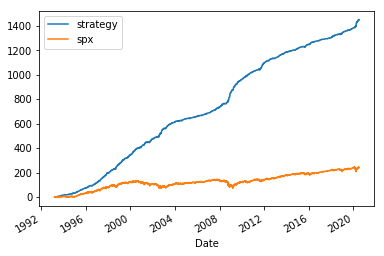

In [9]:
equity_curve.plot()